In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Analyzing movie posters in BigQuery with Gemini 1.5 Flash

<table align="left">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fapplying-llms-to-data%2Fanalyze-poster-images-in-bigquery%2Fposter_image_analysis.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/analyze-poster-images-in-bigquery/poster_image_analysis.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Alicia Williams](https://github.com/aliciawilliams) |

## Overview

The objective is to demonstrate how to use the Gemini models for analysis in BigQuery, including:


*   Completing setup steps for accessing Vertex AI (including Gemini models) from BigQuery
*   Creating an Object Table for the unstructured dataset being analyzed
*   Creating the remote model in BigQuery for Gemini 1.5 Flash
*   Performing analysis over the object table using the Gemini model
*   Joining analysis results back to structured table for deeper insights


## How to open this notebook in BigQuery Studio

This notebook was written to be compatible for use within BigQuery Studio. To open this notebook, click to [Open in Colab Enterprise](https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fgist.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fapplying-llms-to-data%2Fanalyze-poster-images-in-bigquery%2Fposter_image_analysis.ipynb). This will open a new window in the Cloud Console and prompt you to confirm import. Then, navigate to **BigQuery**, where you will find the notebook available in the **Explorer pane** under **Notebooks**.

## About the dataset

The dataset of movie poster images used in this demo are stored in a public Google Cloud Storage bucket: [`gs://cloud-samples-data/vertex-ai/dataset-management/datasets/classic-movie-posters`](https://console.cloud.google.com/storage/browser/cloud-samples-data/vertex-ai/dataset-management/datasets/classic-movie-posters)

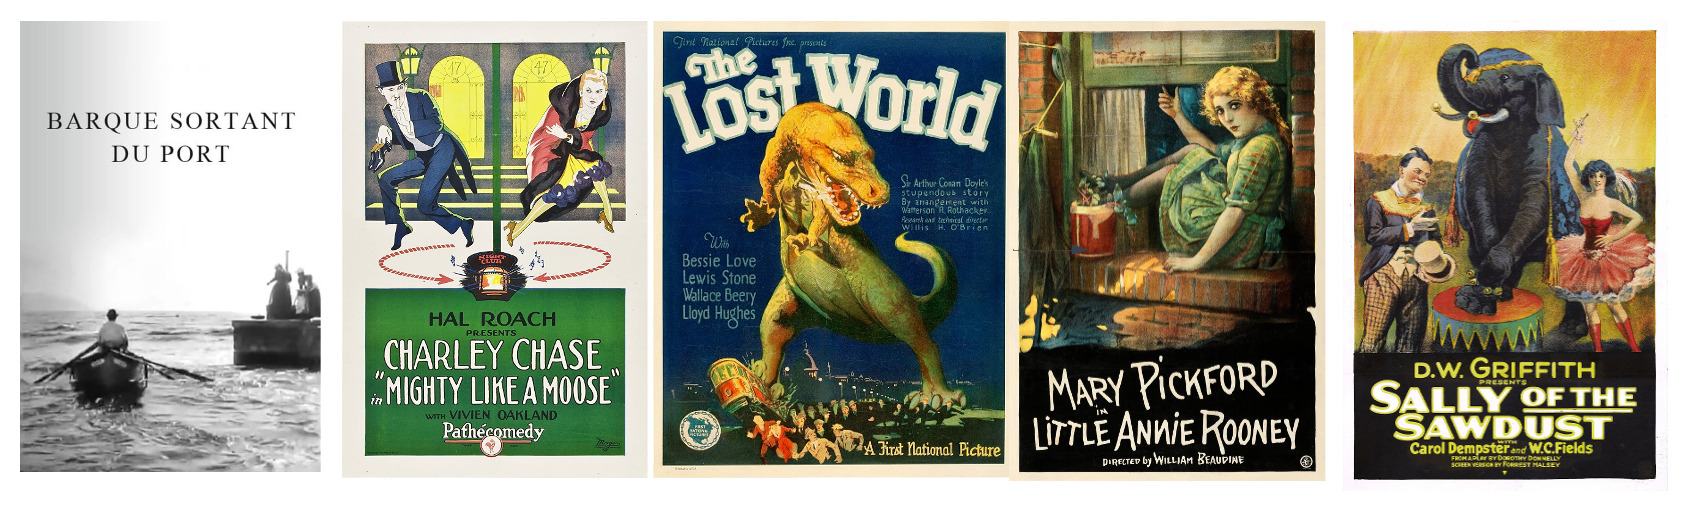

## Services and Costs

This tutorial uses the following Google Cloud data analytics and ML services, they are billable components of Google Cloud:

* BigQuery & BigQuery ML [(pricing)](https://cloud.google.com/bigquery/pricing)
* Vertex AI API [(pricing)](https://cloud.google.com/vertex-ai/pricing)

Use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


# Setup steps for accessing Vertex AI models from BigQuery

## Enable the Vertex AI and BigQuery Connection APIs

In [ ]:
!gcloud services enable aiplatform.googleapis.com bigqueryconnection.googleapis.com

## Create a Cloud resource connection

In [ ]:
!bq mk --connection --location=us \
    --connection_type=CLOUD_RESOURCE gemini_conn

## Grant the "Vertex AI User" role to the service account used by the Cloud resource connection
*Note: This demo analyzes a dataset that sits in a public Cloud Storage bucket. When analyzing a dataset in a non-public bucket, the service account will also need "Storage Object Viewer" role on that storage bucket.*

In [ ]:
SERVICE_ACCT = !bq show --format=prettyjson --connection us.gemini_conn | grep "serviceAccountId" | cut -d '"' -f 4
SERVICE_ACCT_EMAIL = SERVICE_ACCT[-1]

In [ ]:
import os

PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role=roles/aiplatform.user

# Create an object table for the movie poster images

## Create a new dataset named `'gemini_demo'`

In [ ]:
%%bigquery
CREATE SCHEMA
  `gemini_demo` OPTIONS (location = 'US');

## Create an object table referencing Google Cloud Storage bucket

In [ ]:
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE
  `gemini_demo.movie_posters`
WITH CONNECTION `us.gemini_conn`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://cloud-samples-data/vertex-ai/dataset-management/datasets/classic-movie-posters/*']
  );

# Create the remote model in BigQuery ML

## Create the remote model for Gemini 1.5 Flash in BigQuery ML

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `gemini_demo.gemini_1_5_flash`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS (endpoint = 'gemini-1.5-flash')

# Perform analysis on the movie poster images

## Prompt Gemini 1.5 Flash to analyze the movie poster image object table

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `gemini_demo.movie_posters_results` AS (
  SELECT
    uri,
    ml_generate_text_llm_result
  FROM
    ML.GENERATE_TEXT( MODEL `gemini_demo.gemini_1_5_flash`,
      TABLE `gemini_demo.movie_posters`,
      STRUCT( 0.2 AS temperature,
        'For the movie represented by this poster, what is the movie title and year of release? Answer in JSON format with two keys: title, year. title should be string, year should be integer. Do not use JSON decorators.' AS PROMPT,
        TRUE AS FLATTEN_JSON_OUTPUT)));

In [ ]:
%%bigquery
SELECT * FROM `gemini_demo.movie_posters_results`

## Format model responses into new structured columns

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `gemini_demo.movie_posters_results_formatted` AS (
  SELECT
    uri,
    JSON_VALUE(ml_generate_text_llm_result, "$.title") AS title,
    JSON_VALUE(ml_generate_text_llm_result, "$.year") AS year
  FROM
    `gemini_demo.movie_posters_results` results )

In [ ]:
%%bigquery
SELECT * FROM `gemini_demo.movie_posters_results_formatted`

## Prompt Gemini 1.5 Flash to provide movie summaries for each movie poster image

In [ ]:
%%bigquery
SELECT
  uri,
  title,
  year,
  prompt,
  ml_generate_text_llm_result
FROM
  ML.GENERATE_TEXT( MODEL `gemini_demo.gemini_1_5_flash`,
    (
    SELECT
      CONCAT('Provide a short summary of movie titled ',title, ' from the year ',year,'.') AS prompt,
      uri,
      title,
      year
    FROM
      `gemini_demo.movie_posters_results_formatted`
    LIMIT
      10 ),
    STRUCT(0.2 AS temperature,
      TRUE AS FLATTEN_JSON_OUTPUT));

# Join analysis results with structured data for deeper insights
Using text embeddings to perform similarity joins of movie poster images to a movie reviews dataset in BigQuery

## Create remote model for generating text embeddings

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `gemini_demo.text_embedding`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS (endpoint = 'textembedding-gecko-multilingual')

## Generate text embeddings for title and year associated with movie posters

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `gemini_demo.movie_posters_results_embeddings` AS (
  SELECT
    *
  FROM
    ML.GENERATE_EMBEDDING(
      MODEL `gemini_demo.text_embedding`,
      (
      SELECT
        CONCAT('The movie titled ', title, ' from the year ', year,'.') AS content,
        title,
        year,
        uri
      FROM
        `gemini_demo.movie_posters_results_formatted` ),
      STRUCT(TRUE AS flatten_json_output)));

In [ ]:
%%bigquery
SELECT * FROM `gemini_demo.movie_posters_results_embeddings`

## Generate text embeddings for subset of IMDB dataset

In [ ]:
%%bigquery
# Create table containing movie_id, title, and year for movies in IMDB reviews dataset that were release prior to 1935
CREATE OR REPLACE VIEW
  `gemini_demo.imdb_movies` AS (
  WITH
    reviews AS (
      SELECT
        reviews.movie_id AS movie_id,
        title.primary_title AS title,
        title.start_year AS year,
        reviews.review AS review
      FROM
        `bigquery-public-data.imdb.reviews` reviews
      LEFT JOIN
        `bigquery-public-data.imdb.title_basics` title
      ON
        reviews.movie_id = title.tconst)
  SELECT
    DISTINCT(movie_id),
    title,
    year
  FROM
    reviews
  WHERE
    year < 1935)

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `gemini_demo.imdb_movies_embeddings` AS (
  SELECT
    *
  FROM
    ML.GENERATE_EMBEDDING( MODEL `gemini_demo.text_embedding`,
      (
      SELECT
        CONCAT('The movie titled ', title, ' from the year ', year,'.') AS content,
        title,
        year,
        movie_id
      FROM
        `gemini_demo.imdb_movies` ),
      STRUCT(TRUE AS flatten_json_output) )
  WHERE
    ml_generate_embedding_status = '' );

## Match movie poster images to IMDB `movie_id` using BigQuery `VECTOR_SEARCH`

In [ ]:
%%bigquery
SELECT
  query.uri AS poster_uri,
  query.title AS poster_title,
  query.year AS poster_year,
  base.title AS imdb_title,
  base.year AS imdb_year,
  base.movie_id AS imdb_movie_id,
  distance
FROM
  VECTOR_SEARCH( TABLE `gemini_demo.imdb_movies_embeddings`,
    'ml_generate_embedding_result',
    TABLE `gemini_demo.movie_posters_results_embeddings`,
    'ml_generate_embedding_result',
    top_k => 1,
    distance_type => 'COSINE');

Now let's join some additional information on ratings...

In [ ]:
%%bigquery
SELECT
  query.uri AS poster_uri,
  query.title AS poster_title,
  query.year AS poster_year,
  base.title AS imdb_title,
  base.year AS imdb_year,
  base.movie_id AS imdb_movie_id,
  distance,
  imdb.average_rating,
  imdb.num_votes
FROM
  VECTOR_SEARCH( TABLE `gemini_demo.imdb_movies_embeddings`,
    'ml_generate_embedding_result',
    TABLE `gemini_demo.movie_posters_results_embeddings`,
    'ml_generate_embedding_result',
    top_k => 1,
    distance_type => 'COSINE') DATA
LEFT JOIN
  `bigquery-public-data.imdb.title_ratings` imdb
ON
  base.movie_id = imdb.tconst
ORDER BY
  imdb.average_rating DESC

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial by uncommenting the below:

In [ ]:
#
# !bq rm -r -f $PROJECT_ID:gemini_demo
# !bq rm --connection --project_id=$PROJECT_ID --location=us gemini_conn
#

# Wrap up

In this you have seen an example of how to integrate BQML with Vertex AI LLMs, and given examples of how the `ML.GENERATE_TEXT` function can be applied directly to multimodal data stored in BigQuery, as well as how to generate embeddings with `ML.GENERATE_EMBEDDING`.

Check out our BigQuery ML documentation on [generating text](https://cloud.google.com/bigquery/docs/generate-text) and [generating embeddings](https://cloud.google.com/bigquery/docs/generate-text-embedding) to learn more about generative AI in BigQuery.